# 07/06/22 - First tests of Bayesian fitting with J0037.

In [1]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import os
from os import path
import pickle
from datetime import datetime

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from astropy.cosmology import Planck18 as cosmo  # Planck 2018
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized

# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa

# adamet
from adamet.adamet import adamet

# my functions
from slacs_mge_jampy import crop_center_image
from slacs_mge_jampy import import_center_crop
from slacs_mge_jampy import try_fractions_for_find_galaxy
from slacs_mge_jampy import convert_mge_model_outputs
from slacs_mge_jampy import plot_contours_321
from slacs_mge_jampy import load_2d_kinematics
from slacs_mge_jampy import bin_velocity_maps
from slacs_mge_jampy import rotate_bins
from slacs_mge_jampy import find_half_light
from slacs_mge_jampy import calculate_minlevel
from slacs_mge_jampy import fit_kcwi_sigma_psf
from slacs_mge_jampy import optimize_sigma_psf_fit
from slacs_mge_jampy import estimate_hst_psf
from slacs_mge_jampy import make_gaussian
from slacs_ani_mass_jam import osipkov_merritt_model
from slacs_ani_mass_jam import osipkov_merritt_generalized_model
from slacs_ani_mass_jam import inner_outer_anisotropy_model
from slacs_ani_mass_jam import nfw_generalized_model
from slacs_ani_mass_jam import dark_halo_mge
from slacs_ani_mass_jam import total_mass_mge
from slacs_ani_mass_jam import jam_lnprob
from slacs_ani_mass_jam import jam_lnprob_nfw_constbeta
from slacs_ani_mass_jam import jam_lnprob_nfwgen_constbeta
from slacs_ani_mass_jam import jam_lnprob_nfw_om
from slacs_ani_mass_jam import jam_lnprob_nfwgen_om
from slacs_ani_mass_jam import summary_plot
from slacs_ani_mass_jam import save_fit_parameters
from slacs_ani_mass_jam import get_power_law_slope


################################################################
# some needed information
kcwi_scale = 0.147  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC
# B band (F435W) dust extinction ~ 0.116 from https://irsa.ipac.caltech.edu/applications/DUST/
extinction = 0.116
### photometric zeropoint for F435W as of 2007 was 25.745
photometric_zeropoint = 25.745
# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value

In [2]:
# specify object directory and name

data_dir = '/home/shawn/data/' # data directory
obj_name = 'SDSSJ0037-0942' # e.g. SDSSJ0037-0942
obj_abbr = obj_name[4:9] # e.g. J0029
file_dir = f'{data_dir}CF_mosaics/{obj_name}/' # directory with all files of obj_name

# See if we can import all results and parameters from previous fit. Specify date_time

### '2022_07_06-05_17_55_PM'

In [4]:
date_time = '2022_07_06-05_17_55_PM'
model_dir = f'{file_dir}{date_time}/'

In [5]:
# import the parameters
pars = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_parameters_fit.txt')

# import likelihoods
lnprob = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_likelihood.txt')

# save initial parameters
p0 = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_initial_parameters.txt')

# save initial error estimates
sigpar = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_initial_error_estimates.txt')

# save bounds
bounds = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_bounds.txt')

# import labels
#labels = pd.read_csv(f'{model_dir}{obj_name}_{date_time}_labels.txt').values
labels = [r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$f_{\rm DM}$", r"$\lg(M_\ast/L)$"]

# import kwargs
open_kwargs = open(f"{model_dir}{obj_name}_{date_time}_kwargs.pkl",'rb')
kwargs = pickle.load(open_kwargs)
 

In [6]:
# get best fit, etc
bestfit = pars[np.argmax(lnprob)]  # Best fitting parameters
perc = np.percentile(pars, [15.86, 84.14], axis=0)  # 68% interval
sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of interval (1sigma)

print("\nBest-fitting parameters and 1sigma errors:")
for label, best, sig in zip(labels, bestfit, sig_bestfit):
    print(f"   {label} = {best:#.4g} +/- {sig:#.2g}")


Best-fitting parameters and 1sigma errors:
   $q_{\rm min}$ = 0.7481 +/- 0.058
   $\sigma_z/\sigma_R$ = 0.9750 +/- 0.013
   $f_{\rm DM}$ = 0.003964 +/- 0.011
   $\lg(M_\ast/L)$ = 4.419 +/- 0.0049


In [7]:
                     
# convert to parameters we care about....
qmin = p0[0] # initial qmin
q = bestfit[0] # 
inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
print(f'Best fit inclination is {inc}')
sig_ratio = bestfit[1]
beta = 1 - sig_ratio**2
print(f'Best fit beta is {beta}')

Best fit inclination is 85.39297983495747
Best fit beta is 0.049332366217894164


In [8]:
surf_lum = kwargs['surf_lum']
sigma_lum = kwargs['sigma_lum']
qobs_lum = kwargs['qobs_lum']
distance = kwargs['distance']
xbin = kwargs['xbin']
ybin = kwargs['ybin']
sigmapsf = kwargs['sigmapsf']
normpsf = kwargs['normpsf']
rms = kwargs['rms']
erms = kwargs['erms']
pixsize = kwargs['pixsize']
goodbins = kwargs['goodbins']
plot = kwargs['plot']
model = kwargs['model']
reff = kwargs['reff']

rbreak = 5*reff

# Previous results will plot.


Best-fitting parameters and 1sigma errors:
   $q_{\rm min}$ = 0.7481 +/- 0.058
   $\sigma_z/\sigma_R$ = 0.9750 +/- 0.013
   $f_{\rm DM}$ = 0.003964 +/- 0.011
   $\lg(M_\ast/L)$ = 4.419 +/- 0.0049


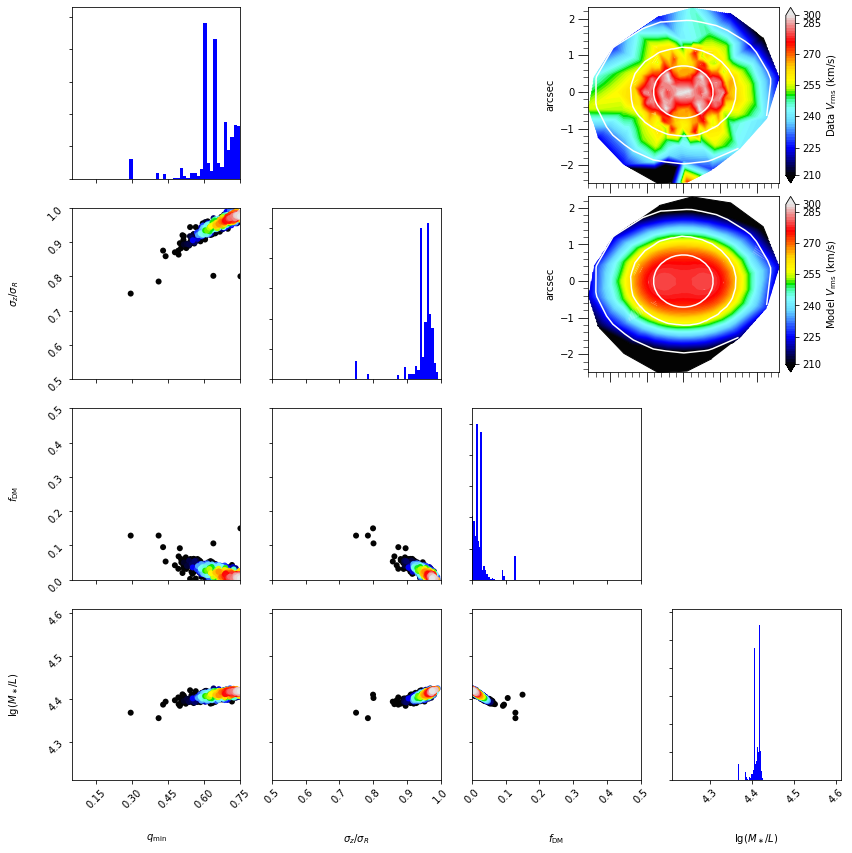

In [9]:
surf_potential, rms_model, flux_model = summary_plot(xbin, ybin, goodbins, rms, pars, lnprob, 
                                                     labels, bounds, kwargs, obj_name, date_time,
                                                     model_dir, jam_lnprob_nfw_constbeta, save=True)

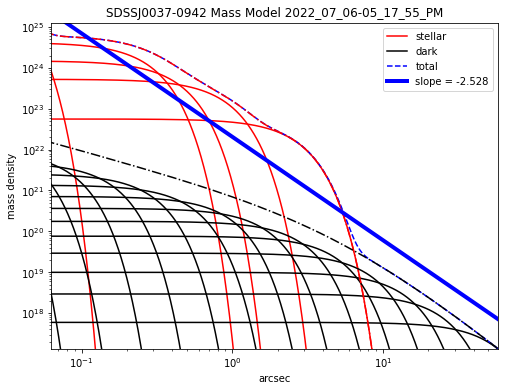

In [10]:
power_law_slope, intercept = get_power_law_slope(surf_potential, reff, surf_lum, 
                                                obj_name, model_dir, 
                                                 date_time, save=True)

# 

In [ ]:
date_time = '2022_07_06-05_17_55_PM'
model_dir = f'{file_dir}model_2022-07-07 15:06:30.868202_nfw_const/'

In [5]:
# import the parameters
pars = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_parameters_fit.txt')

# import likelihoods
lnprob = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_likelihood.txt')

# save initial parameters
p0 = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_initial_parameters.txt')

# save initial error estimates
sigpar = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_initial_error_estimates.txt')

# save bounds
bounds = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_bounds.txt')

# import labels
#labels = pd.read_csv(f'{model_dir}{obj_name}_{date_time}_labels.txt').values
labels = [r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$f_{\rm DM}$", r"$\lg(M_\ast/L)$"]

# import kwargs
open_kwargs = open(f"{model_dir}{obj_name}_{date_time}_kwargs.pkl",'rb')
kwargs = pickle.load(open_kwargs)
 

In [6]:
# get best fit, etc
bestfit = pars[np.argmax(lnprob)]  # Best fitting parameters
perc = np.percentile(pars, [15.86, 84.14], axis=0)  # 68% interval
sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of interval (1sigma)

print("\nBest-fitting parameters and 1sigma errors:")
for label, best, sig in zip(labels, bestfit, sig_bestfit):
    print(f"   {label} = {best:#.4g} +/- {sig:#.2g}")


Best-fitting parameters and 1sigma errors:
   $q_{\rm min}$ = 0.7481 +/- 0.058
   $\sigma_z/\sigma_R$ = 0.9750 +/- 0.013
   $f_{\rm DM}$ = 0.003964 +/- 0.011
   $\lg(M_\ast/L)$ = 4.419 +/- 0.0049


In [7]:
                     
# convert to parameters we care about....
qmin = p0[0] # initial qmin
q = bestfit[0] # 
inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
print(f'Best fit inclination is {inc}')
sig_ratio = bestfit[1]
beta = 1 - sig_ratio**2
print(f'Best fit beta is {beta}')

Best fit inclination is 85.39297983495747
Best fit beta is 0.049332366217894164


In [8]:
surf_lum = kwargs['surf_lum']
sigma_lum = kwargs['sigma_lum']
qobs_lum = kwargs['qobs_lum']
distance = kwargs['distance']
xbin = kwargs['xbin']
ybin = kwargs['ybin']
sigmapsf = kwargs['sigmapsf']
normpsf = kwargs['normpsf']
rms = kwargs['rms']
erms = kwargs['erms']
pixsize = kwargs['pixsize']
goodbins = kwargs['goodbins']
plot = kwargs['plot']
model = kwargs['model']
reff = kwargs['reff']

rbreak = 5*reff

# Previous results will plot.


Best-fitting parameters and 1sigma errors:
   $q_{\rm min}$ = 0.7481 +/- 0.058
   $\sigma_z/\sigma_R$ = 0.9750 +/- 0.013
   $f_{\rm DM}$ = 0.003964 +/- 0.011
   $\lg(M_\ast/L)$ = 4.419 +/- 0.0049


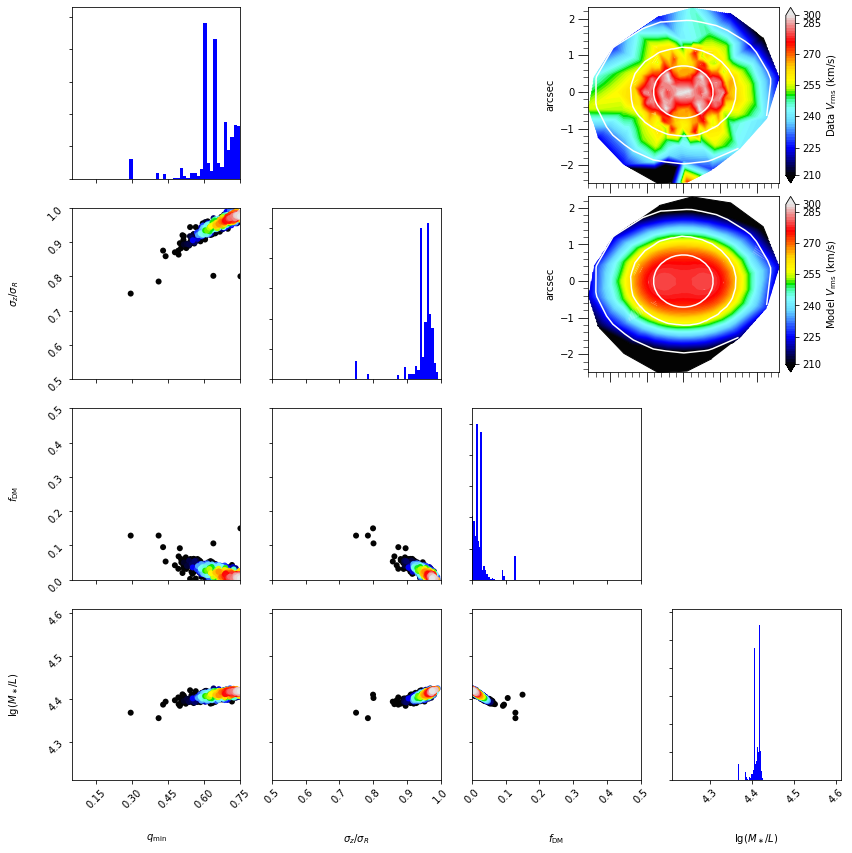

In [9]:
surf_potential, rms_model, flux_model = summary_plot(xbin, ybin, goodbins, rms, pars, lnprob, 
                                                     labels, bounds, kwargs, obj_name, date_time,
                                                     model_dir, jam_lnprob_nfw_constbeta, save=True)

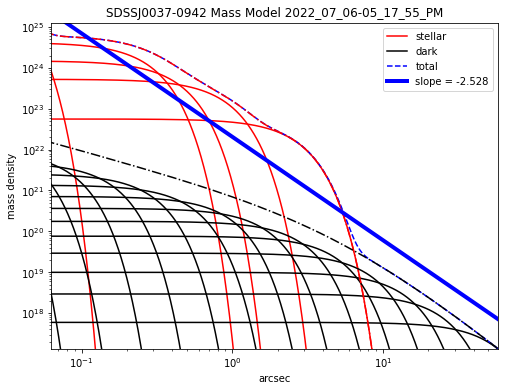

In [10]:
power_law_slope, intercept = get_power_law_slope(surf_potential, reff, surf_lum, 
                                                obj_name, model_dir, 
                                                 date_time, save=True)

__________

# Now we can do new fits by tweaking things... except we'll have to create new jam_lnprob to account for different models of anisotropy and mass profiles.

# Let's do this again... Now that I've corrected the dark_halo_mge to go down to lower radii

Started AdaMet please wait...
Progress is printed periodically


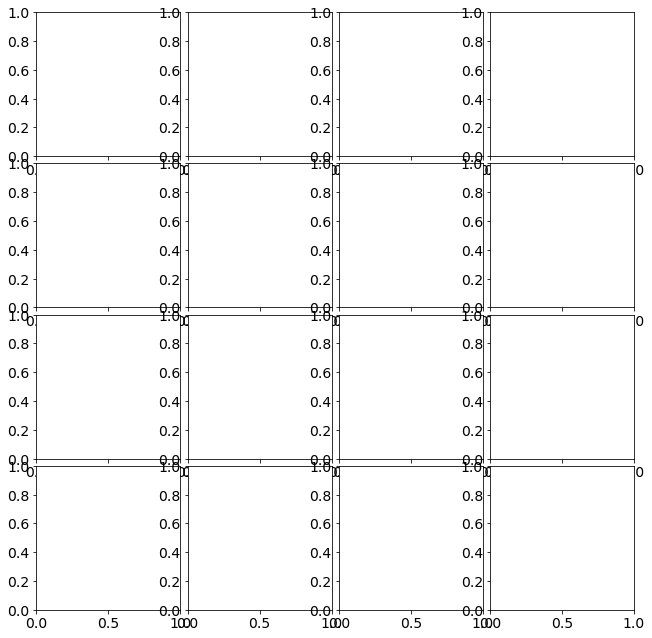

adamet: 1.0 % done; 30.0 % accepted
adamet: 2.0 % done; 15.0 % accepted
adamet: 3.0 % done; 10.0 % accepted
adamet: 4.0 % done; 7.5 % accepted
adamet: 5.0 % done; 6.0 % accepted
adamet: 6.0 % done; 5.0 % accepted
adamet: 7.0 % done; 5.7 % accepted
adamet: 8.0 % done; 5.0 % accepted
adamet: 9.0 % done; 4.4 % accepted
adamet: 10.0 % done; 4.0 % accepted
adamet: 11.0 % done; 3.6 % accepted
adamet: 12.0 % done; 3.3 % accepted
adamet: 13.0 % done; 3.1 % accepted
adamet: 14.0 % done; 2.9 % accepted
adamet: 15.0 % done; 2.7 % accepted
adamet: 16.0 % done; 2.5 % accepted
adamet: 17.0 % done; 2.4 % accepted
adamet: 18.0 % done; 2.2 % accepted
adamet: 19.0 % done; 2.1 % accepted
adamet: 20.0 % done; 2.0 % accepted
adamet: 21.0 % done; 1.9 % accepted
adamet: 22.0 % done; 1.8 % accepted
adamet: 23.0 % done; 1.7 % accepted
adamet: 24.0 % done; 1.7 % accepted
adamet: 25.0 % done; 1.6 % accepted
adamet: 26.0 % done; 1.5 % accepted
adamet: 27.0 % done; 1.5 % accepted
adamet: 28.0 % done; 1.4 % accepte

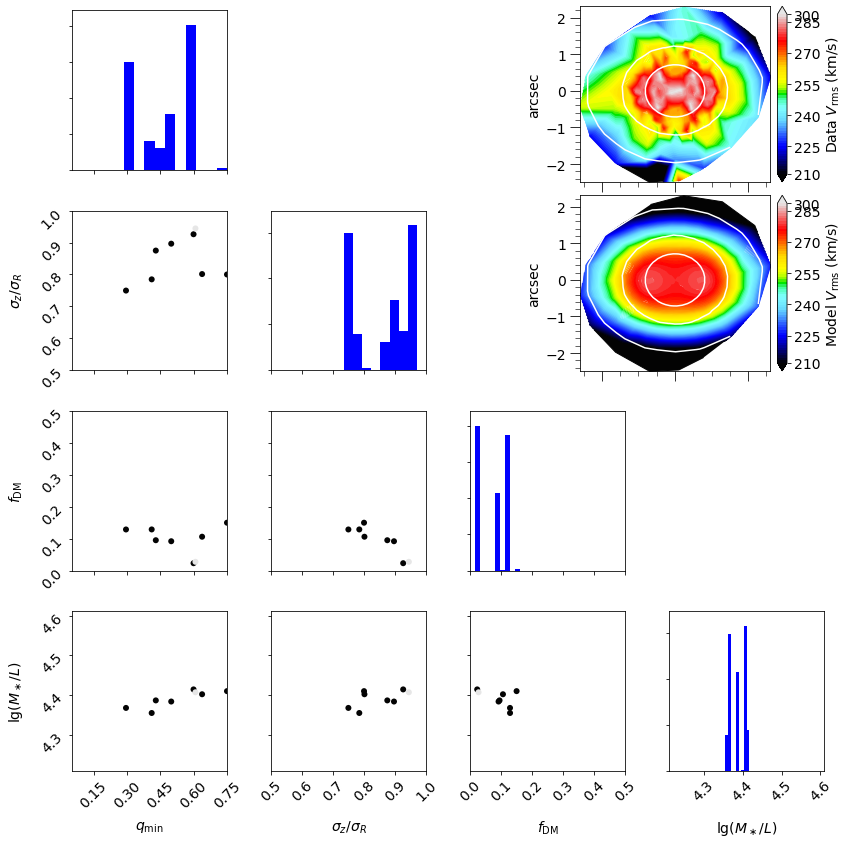

In [21]:
# Use cylindrical b/c its cheaper on time
kwargs['align'] = 'cyl'

# fewer steps so it's shorter as well
nstep = 1000

# set the date_time variable for saving
date_time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")

print("Started AdaMet please wait...")
print("Progress is printed periodically")
pars, lnprob = adamet(jam_lnprob, p0, sigpar, bounds, nstep, fignum=1,
                      kwargs=kwargs, nprint=nstep/100, labels=labels, seed=2)

summary_plot(xbin, ybin, goodbins, rms, pars, lnprob, labels, bounds, kwargs)

# Okay... it needs to be done with more steps

Started AdaMet please wait...
Progress is printed periodically


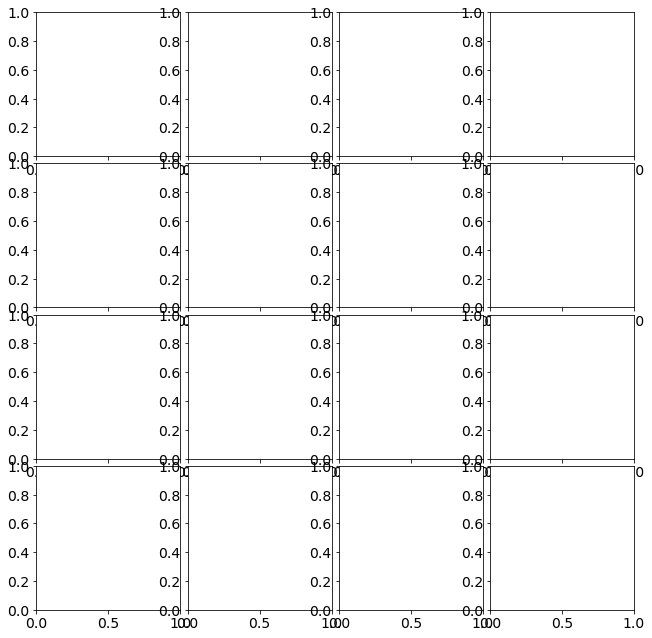

adamet: 5.0 % done; 1.2 % accepted
adamet: 10.0 % done; 0.8 % accepted
adamet: 15.0 % done; 0.5 % accepted
adamet: 20.0 % done; 0.4 % accepted
adamet: 25.0 % done; 0.3 % accepted
adamet: 30.0 % done; 0.3 % accepted
adamet: 35.0 % done; 0.3 % accepted
adamet: 40.0 % done; 0.2 % accepted
adamet: 45.0 % done; 0.2 % accepted
adamet: 50.0 % done; 0.2 % accepted
adamet: 55.0 % done; 0.9 % accepted
adamet: 60.0 % done; 2.0 % accepted
adamet: 65.0 % done; 2.6 % accepted
adamet: 70.0 % done; 3.3 % accepted
adamet: 75.0 % done; 3.7 % accepted
adamet: 80.0 % done; 3.8 % accepted
adamet: 85.0 % done; 4.0 % accepted
adamet: 90.0 % done; 4.1 % accepted
adamet: 95.0 % done; 4.3 % accepted
adamet: 100.0 % done; 4.6 % accepted
adamet: done. Total time 1479.08 seconds

Best-fitting parameters and 1sigma errors:
   $q_{\rm min}$ = 0.7481 +/- 0.058
   $\sigma_z/\sigma_R$ = 0.9750 +/- 0.013
   $f_{\rm DM}$ = 0.003964 +/- 0.011
   $\lg(M_\ast/L)$ = 4.419 +/- 0.0049


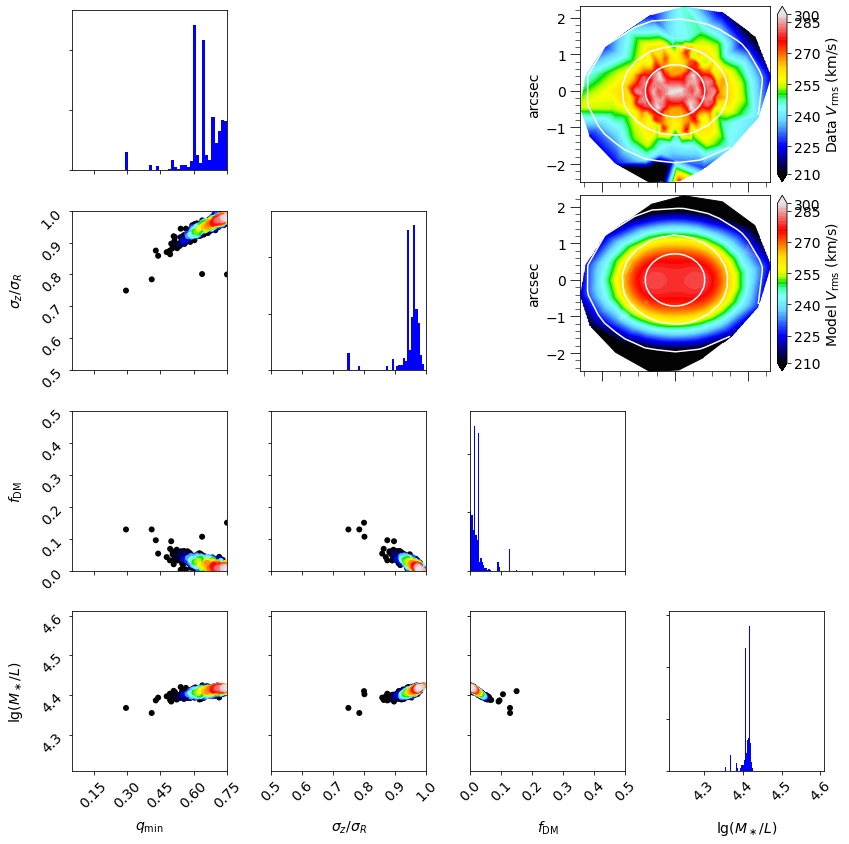

In [22]:
# Use cylindrical b/c its cheaper on time
kwargs['align'] = 'cyl'

# fewer steps so it's shorter as well
nstep = 10000

# set the date_time variable for saving
date_time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")

print("Started AdaMet please wait...")
print("Progress is printed periodically")
pars, lnprob = adamet(jam_lnprob, p0, sigpar, bounds, nstep, fignum=1,
                      kwargs=kwargs, nprint=nstep/20, labels=labels, seed=2)

summary_plot(xbin, ybin, goodbins, rms, pars, lnprob, labels, bounds, kwargs)

In [26]:
# import the parameters
np.savetxt(f'{file_dir}{obj_name}_{date_time}_parameters_fit.txt', pars)

# import likelihoods
np.savetxt(f'{file_dir}{obj_name}_{date_time}_likelihood.txt', lnprob)

# save initial parameters
np.savetxt(f'{file_dir}{obj_name}_{date_time}_initial_parameters.txt', p0)

# save initial error estimates
np.savetxt(f'{file_dir}{obj_name}_{date_time}_initial_error_estimates.txt', sigpar)

# save bounds
np.savetxt(f'{file_dir}{obj_name}_{date_time}_bounds.txt', bounds)

# import labels
#np.savetxt(f'{file_dir}{obj_name}_{date_time}_labels.txt', labels)

# import kwargs
f = open(f"{file_dir}{obj_name}_{date_time}_kwargs.pkl",'wb')
# write the python object (dict) to pickle file
pickle.dump(kwargs,f)
# close file
f.close()
 

In [28]:
import os

In [32]:
# Use this to organize the models better.
os.mkdir(f'{file_dir}{date_time}')

FileExistsError: [Errno 17] File exists: '/home/shawn/data/CF_mosaics/SDSSJ0037-0942/2022_07_06-05_17_55_PM'